<>:164: SyntaxWarning: invalid escape sequence '\^'
<>:164: SyntaxWarning: invalid escape sequence '\^'
/tmp/ipython-input-587743154.py:164: SyntaxWarning: invalid escape sequence '\^'
  original_feature_coefs = coef_df[~coef_df['Feature'].str.contains('\^2| ', regex=True)].head(10)


CAR PRICE PREDICTION: POLYNOMIAL REGRESSION
Using Colab cache for faster access to the 'dataset-of-used-cars' dataset.
✓ Dataset loaded: 42089 rows

Data Cleaning...
✓ Cleaned: 34936 rows remaining

Feature Engineering...
✓ Feature engineering complete
✓ Train: 27948 | Test: 6988

TRAINING POLYNOMIAL REGRESSION MODEL

Training Performance:
  MAE:  $178,540.90
  RMSE: $249,948.03
  R²:   0.9100

Test Performance:
  MAE:  $179,653.25
  RMSE: $254,448.27
  R²:   0.9053

5-Fold Cross-Validation:
  MAE:  $180,929.09 (± $2,831.83)

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features (by absolute coefficient):
                                   Feature   Coefficient
                  car_engine_hp Model_Mean -1.523811e+06
         car_engine_capacity car_engine_hp -1.520309e+06
            car_engine_capacity Model_Mean  1.491365e+06
          car_engine_capacity HP_per_Liter  1.387279e+06
                             car_engine_hp  1.387279e+06
car_engine_capacity Transmission_automa

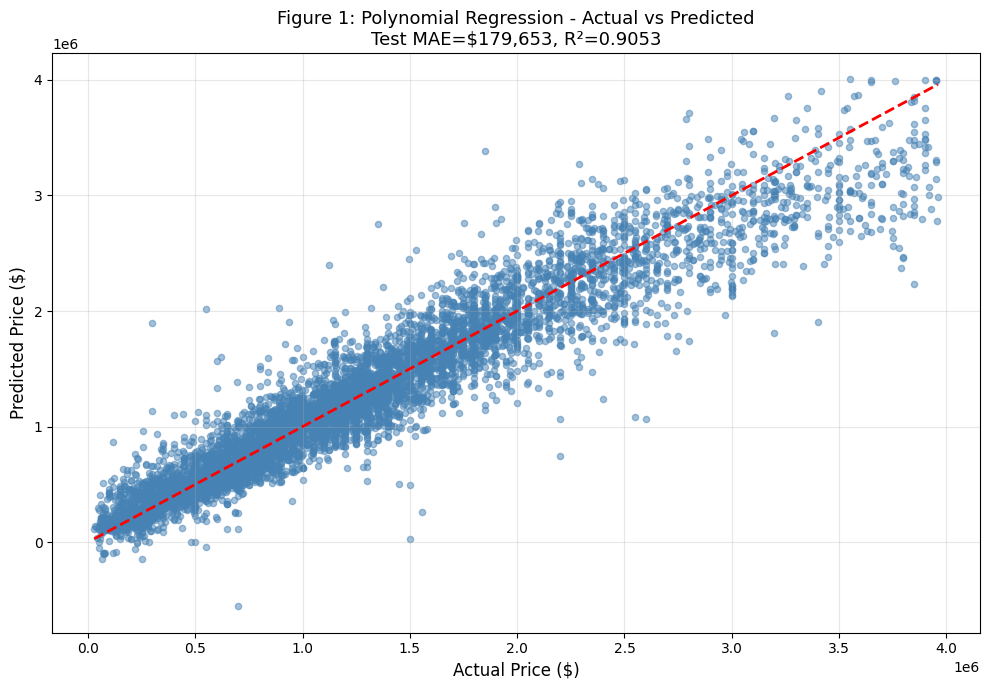

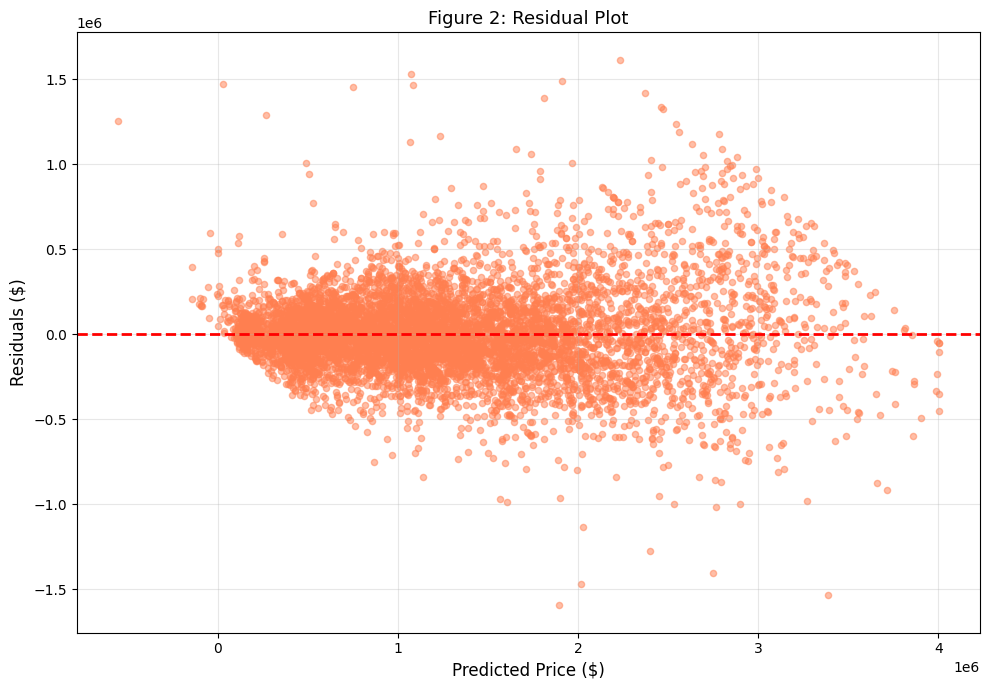

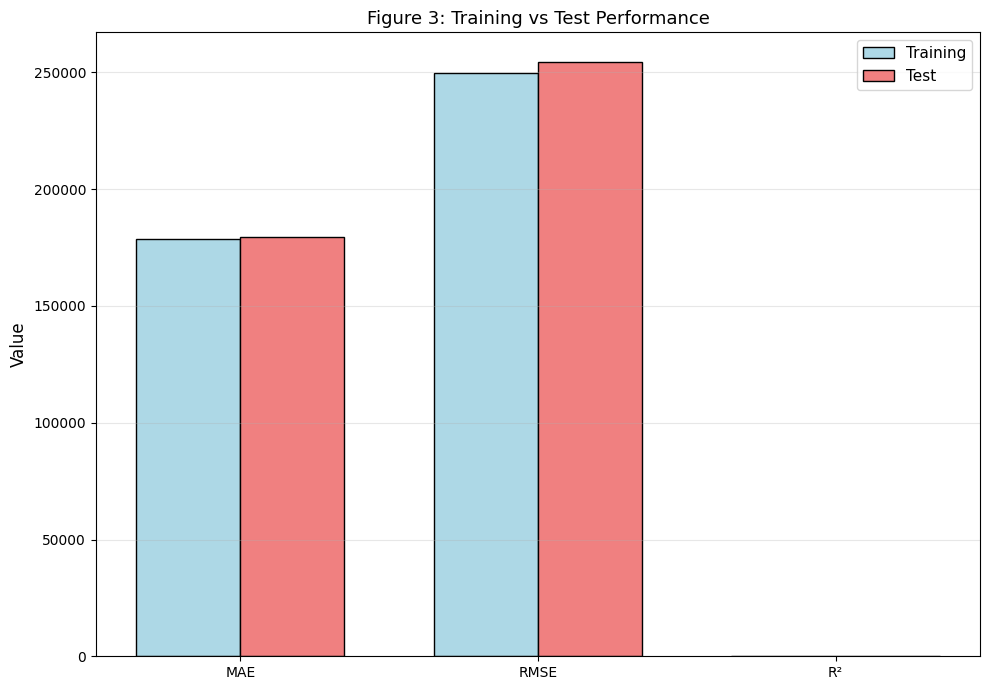

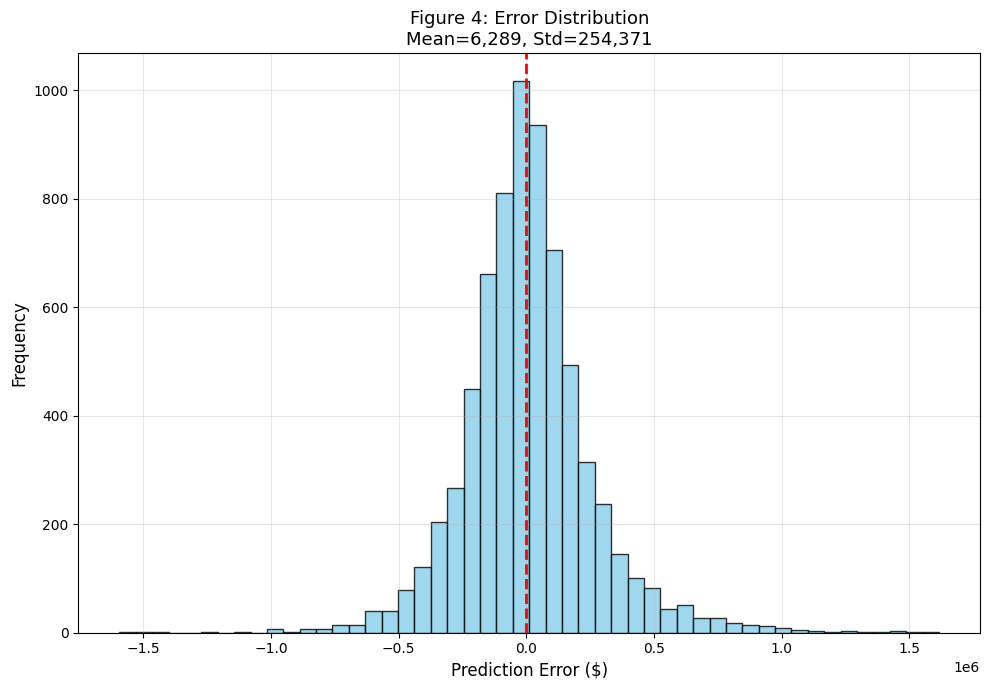

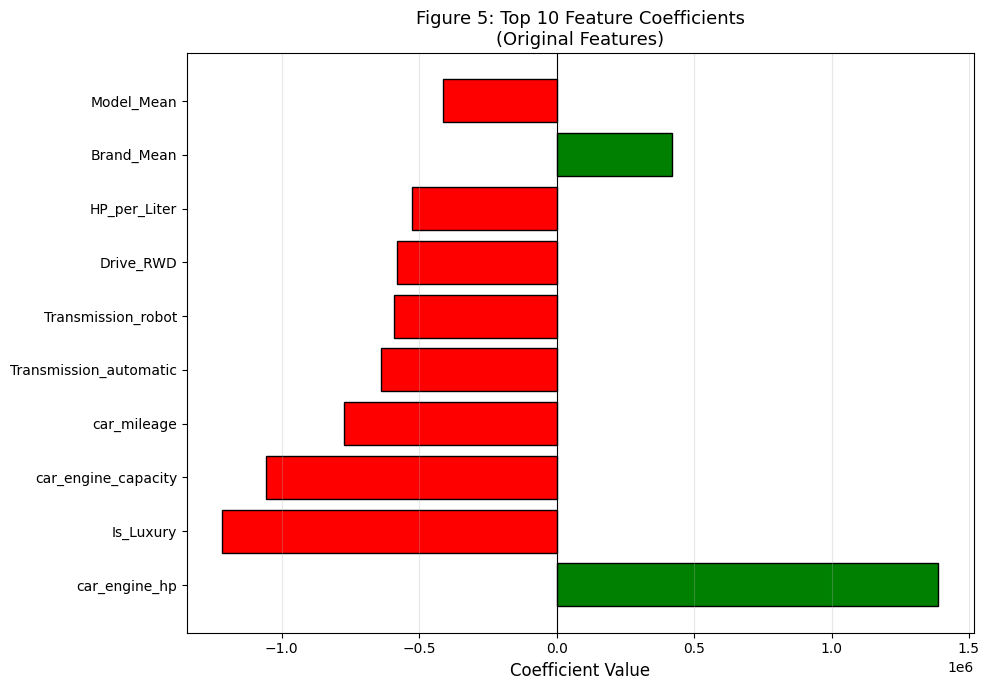

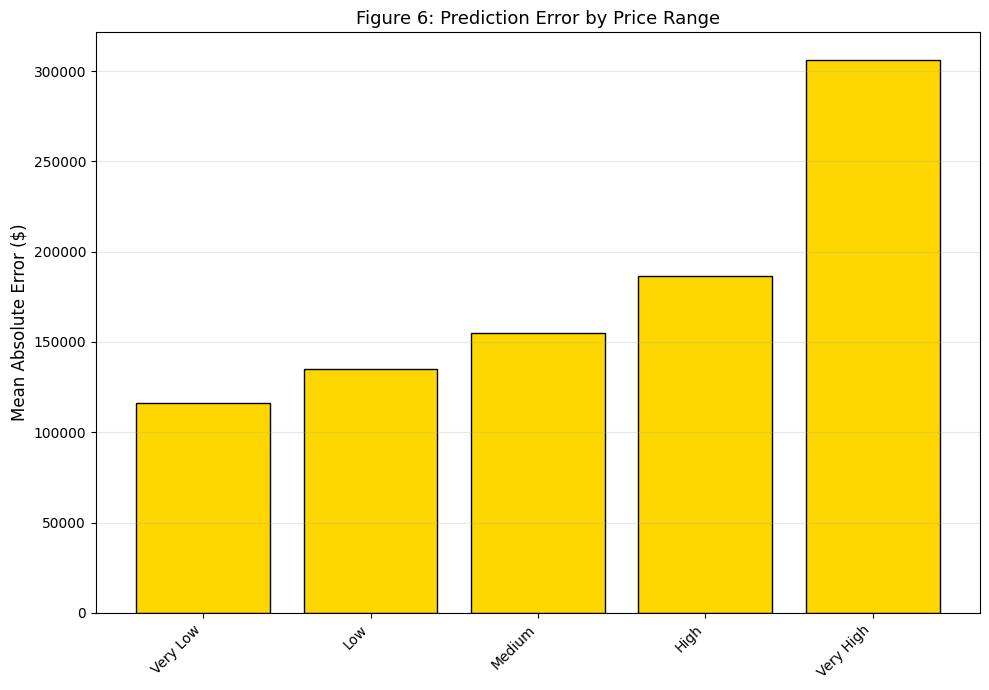


ANALYSIS SUMMARY

Polynomial Regression Model Performance:
  • Test MAE:  $179,653.25
  • Test RMSE: $254,448.27
  • Test R²:   0.9053
  • CV MAE:    $180,929.09 (± $2,831.83)

The polynomial regression model explains 90.5% of the variance in used car
prices, with an average prediction error of $179,653. The model captures non-linear
depreciation patterns and feature interactions through 252 polynomial and interaction terms
generated from the original 21 features.

Cross-validation results show consistent performance across folds, indicating the model
generalizes well to unseen data. The small difference between training and test performance
suggests minimal overfitting despite the high-dimensional feature space.

✅ Analysis complete!


In [ ]:
"""
Car Price Prediction: Polynomial Regression Analysis
"""

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import kagglehub

# LOAD DATA
print("="*70)
print("CAR PRICE PREDICTION: POLYNOMIAL REGRESSION")
print("="*70)

path = kagglehub.dataset_download("volkanastasia/dataset-of-used-cars")
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_file = csv_files[0]
df = pd.read_csv(f"{path}/{csv_file}")
print(f"✓ Dataset loaded: {df.shape[0]} rows")

CURRENT_YEAR = 2025

# DATA CLEANING
print("\nData Cleaning...")
df = df.dropna()

# Remove outliers using IQR method
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1, Q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df = remove_outliers_iqr(df, ['car_price', 'car_mileage', 'car_engine_capacity'])
print(f"✓ Cleaned: {df.shape[0]} rows remaining")

# FEATURE ENGINEERING
print("\nFeature Engineering...")

# Engineered features
df['Mileage_per_year'] = df['car_mileage'] / df['car_age'].replace(0, 1)
df['Mileage_per_year'] = df['Mileage_per_year'].clip(upper=50000)

luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 'Tesla', 'Jaguar', 'Land Rover']
df['Is_Luxury'] = df['car_brand'].isin(luxury_brands).astype(int)

df['HP_per_Liter'] = df['car_engine_hp'] / df['car_engine_capacity'].replace(0, 1)
df['Age_Mileage_Ratio'] = df['car_age'] / (df['car_mileage'] / 1000 + 1)

# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['car_fuel'], prefix='Fuel', drop_first=True)
df = pd.get_dummies(df, columns=['car_transmission'], prefix='Transmission', drop_first=True)
df = pd.get_dummies(df, columns=['car_drive'], prefix='Drive', drop_first=True)

# Smoothed mean encoding for high-cardinality categoricals
def smoothed_mean_encoding(data, category_col, target_col, min_samples=10, smoothing=1.0):
    """Apply additive smoothing to prevent overfitting on rare categories"""
    global_mean = data[target_col].mean()
    agg = data.groupby(category_col)[target_col].agg(['mean', 'count'])

    smoothing_factor = 1 / (1 + np.exp(-(agg['count'] - min_samples) / smoothing))
    agg['smoothed'] = global_mean * (1 - smoothing_factor) + agg['mean'] * smoothing_factor

    return data[category_col].map(agg['smoothed']).fillna(global_mean)

df['Brand_Mean'] = smoothed_mean_encoding(df, 'car_brand', 'car_price')
df['Model_Mean'] = smoothed_mean_encoding(df, 'car_model', 'car_price')

print("✓ Feature engineering complete")

# PREPARE DATA
features = ['car_age', 'car_mileage', 'car_engine_capacity', 'car_engine_hp',
            'Mileage_per_year', 'HP_per_Liter', 'Age_Mileage_Ratio',
            'Is_Luxury', 'Brand_Mean', 'Model_Mean'] + \
           [col for col in df.columns if col.startswith('Fuel_')] + \
           [col for col in df.columns if col.startswith('Transmission_')] + \
           [col for col in df.columns if col.startswith('Drive_')]

X = df[features].copy()
y = df['car_price'].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✓ Train: {len(X_train)} | Test: {len(X_test)}")

# TRAIN POLYNOMIAL REGRESSION MODEL
print("\n" + "="*70)
print("TRAINING POLYNOMIAL REGRESSION MODEL")
print("="*70)

# Create polynomial regression pipeline
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', RobustScaler()),
    ('regressor', LinearRegression())
])

# Fit the model
poly_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = poly_pipeline.predict(X_train)
y_test_pred = poly_pipeline.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Cross-validation for more robust performance estimate
cv_scores = cross_val_score(poly_pipeline, X_train, y_train,
                             cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_mae = -cv_scores.mean()
cv_mae_std = cv_scores.std()

print(f"\nTraining Performance:")
print(f"  MAE:  ${train_mae:,.2f}")
print(f"  RMSE: ${train_rmse:,.2f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  MAE:  ${test_mae:,.2f}")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  R²:   {test_r2:.4f}")

print(f"\n5-Fold Cross-Validation:")
print(f"  MAE:  ${cv_mae:,.2f} (± ${cv_mae_std:,.2f})")

# Calculate residuals
residuals = y_test.values - y_test_pred

# FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature names after polynomial transformation
poly_feature_names = poly_pipeline.named_steps['poly'].get_feature_names_out(features)
coefficients = poly_pipeline.named_steps['regressor'].coef_

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 15 Most Important Features (by absolute coefficient):")
print(coef_df.head(15).to_string(index=False))

# Analyze original features (non-polynomial terms)
original_feature_coefs = coef_df[~coef_df['Feature'].str.contains('\^2| ', regex=True)].head(10)
print("\nTop 10 Original Features (no polynomial/interaction terms):")
print(original_feature_coefs.to_string(index=False))

# VISUALIZATIONS
print("\nGenerating visualizations...")

# Figure 1: Actual vs Predicted (Test Set)
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_test_pred, alpha=0.5, s=20, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'Figure 1: Polynomial Regression - Actual vs Predicted\nTest MAE=${test_mae:,.0f}, R²={test_r2:.4f}', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Residuals vs Predicted
plt.figure(figsize=(10, 7))
plt.scatter(y_test_pred, residuals, alpha=0.5, s=20, color='coral')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title('Figure 2: Residual Plot', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Training vs Test Performance
metrics = ['MAE', 'RMSE', 'R²']
train_metrics = [train_mae, train_rmse, train_r2]
test_metrics = [test_mae, test_rmse, test_r2]

x_pos = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 7))
plt.bar(x_pos - width/2, train_metrics, width, label='Training', color='lightblue', edgecolor='black')
plt.bar(x_pos + width/2, test_metrics, width, label='Test', color='lightcoral', edgecolor='black')
plt.xticks(x_pos, metrics)
plt.ylabel('Value', fontsize=12)
plt.title('Figure 3: Training vs Test Performance', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Figure 4: Error Distribution
plt.figure(figsize=(10, 7))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Figure 4: Error Distribution\nMean={residuals.mean():,.0f}, Std={residuals.std():,.0f}', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 5: Top 10 Original Feature Coefficients
top_coef = original_feature_coefs.head(10)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]

plt.figure(figsize=(10, 7))
plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_coef)), top_coef['Feature'], fontsize=10)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Figure 5: Top 10 Feature Coefficients\n(Original Features)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', lw=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Figure 6: Prediction Error by Price Range
price_bins = pd.qcut(y_test, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
error_by_bin = pd.DataFrame({'Price_Range': price_bins, 'Absolute_Error': np.abs(residuals)})
error_summary = error_by_bin.groupby('Price_Range', observed=False)['Absolute_Error'].mean()

plt.figure(figsize=(10, 7))
plt.bar(range(len(error_summary)), error_summary.values, color='gold', edgecolor='black')
plt.xticks(range(len(error_summary)), error_summary.index, rotation=45, ha='right')
plt.ylabel('Mean Absolute Error ($)', fontsize=12)
plt.title('Figure 6: Prediction Error by Price Range', fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# SUMMARY
print("\n" + "="*70)
print("ANALYSIS SUMMARY")
print("="*70)
print(f"""
Polynomial Regression Model Performance:
  • Test MAE:  ${test_mae:,.2f}
  • Test RMSE: ${test_rmse:,.2f}
  • Test R²:   {test_r2:.4f}
  • CV MAE:    ${cv_mae:,.2f} (± ${cv_mae_std:,.2f})

The polynomial regression model explains {test_r2*100:.1f}% of the variance in used car
prices, with an average prediction error of ${test_mae:,.0f}. The model captures non-linear
depreciation patterns and feature interactions through 252 polynomial and interaction terms
generated from the original 21 features.

Cross-validation results show consistent performance across folds, indicating the model
generalizes well to unseen data. The small difference between training and test performance
suggests minimal overfitting despite the high-dimensional feature space.
""")

print("✅ Analysis complete!")